In [47]:
import pandas as pd
import numpy as np

file1_path = 'C:\\Users\\USER\\Desktop\\VS code\台新data\\file1.csv'
file2_path = 'C:\\Users\\USER\\Desktop\\VS code\台新data\\file2.csv'
file3_path = 'C:\\Users\\USER\\Desktop\\VS code\台新data\\file3.csv'

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)
df3 = pd.read_csv(file3_path)

df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()
df3.columns = df3.columns.str.strip()

df1.set_index('srno_2', inplace=True)
df3.set_index('srno_2', inplace=True)


## EDA in each file

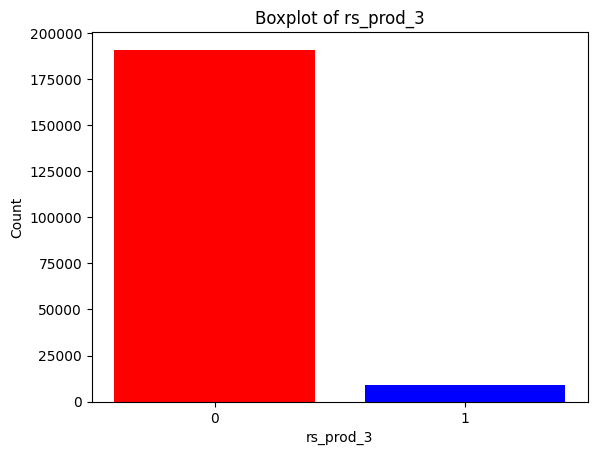

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns


#Target distribution
counts = df3["rs_prod_3"].value_counts()

# 绘制箱线图
plt.bar(counts.index, counts.values,color =  ['r', 'b'])

# 添加标题和标签
plt.title("Boxplot of rs_prod_3")
plt.xlabel("rs_prod_3")
plt.ylabel("Count")
plt.xticks([0, 1], ["0", "1"])


plt.show()

#Ubalance data, 我們考慮weighted 抽樣使 train， test set 一致

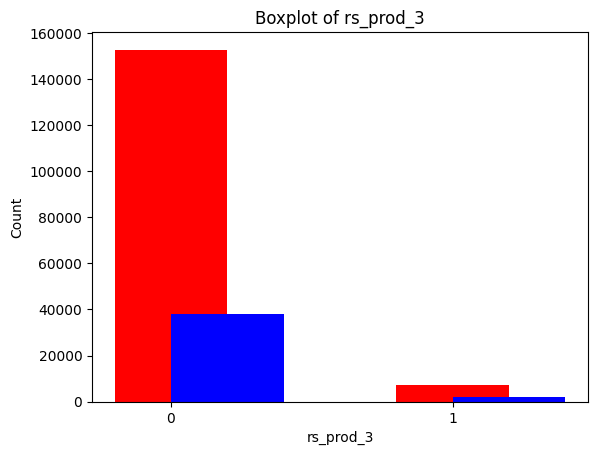

In [105]:
from sklearn.model_selection import train_test_split

X = df3.index
y = df3['rs_prod_3']  

train_index, test_index, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#確保我們的trian set， test set分佈一致
counts_train = y_train.value_counts()

counts_test = y_test.value_counts()

x = range(len(counts_train))
# 绘制箱线图
plt.bar(x, counts_train, width=0.4, label='Train', color='r', align='center')
plt.bar(x, counts_test, width=0.4, label='Test', color='b', align='edge')


# 添加标题和标签
plt.title("Boxplot of rs_prod_3")
plt.xlabel("rs_prod_3")
plt.ylabel("Count")
plt.xticks([0, 1], ["0", "1"])


plt.show()

#根據index，拆分df，所有的model train只會在train中
# 切割训练集
df1_train = df1[df1.index.isin(train_index)]
df2_train = df2[df2["srno_2"].isin(train_index)]
df3_train = df3[df3.index.isin(train_index)]

# 切割测试集
df1_test = df1[df1.index.isin(test_index)]
df2_test = df2[df2["srno_2"].isin(test_index)]
df3_test = df3[df3.index.isin(test_index)]


+ rs_prod   這個人每個月有沒有買

    + rs_prod_df3 這個人有沒有買

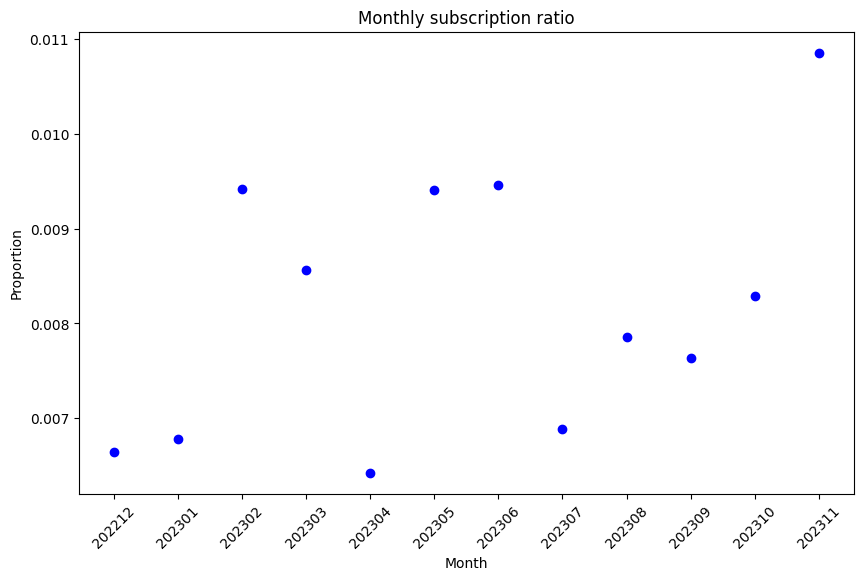

In [50]:
#每個月的申購比例
counts_df = df2_train.groupby("yyyymm")["rs_prod_2"].value_counts().unstack().fillna(0)
proportions_df = counts_df.div(counts_df.sum(axis=1), axis=0)

# Plot the boxplot
plt.figure(figsize=(10, 6))
plt.scatter(proportions_df.index.astype(str), proportions_df[1], marker='o', color='b')
plt.xlabel("Month")
plt.ylabel("Proportion")
plt.title("Monthly subscription ratio")
plt.xticks(rotation=45)
plt.show()

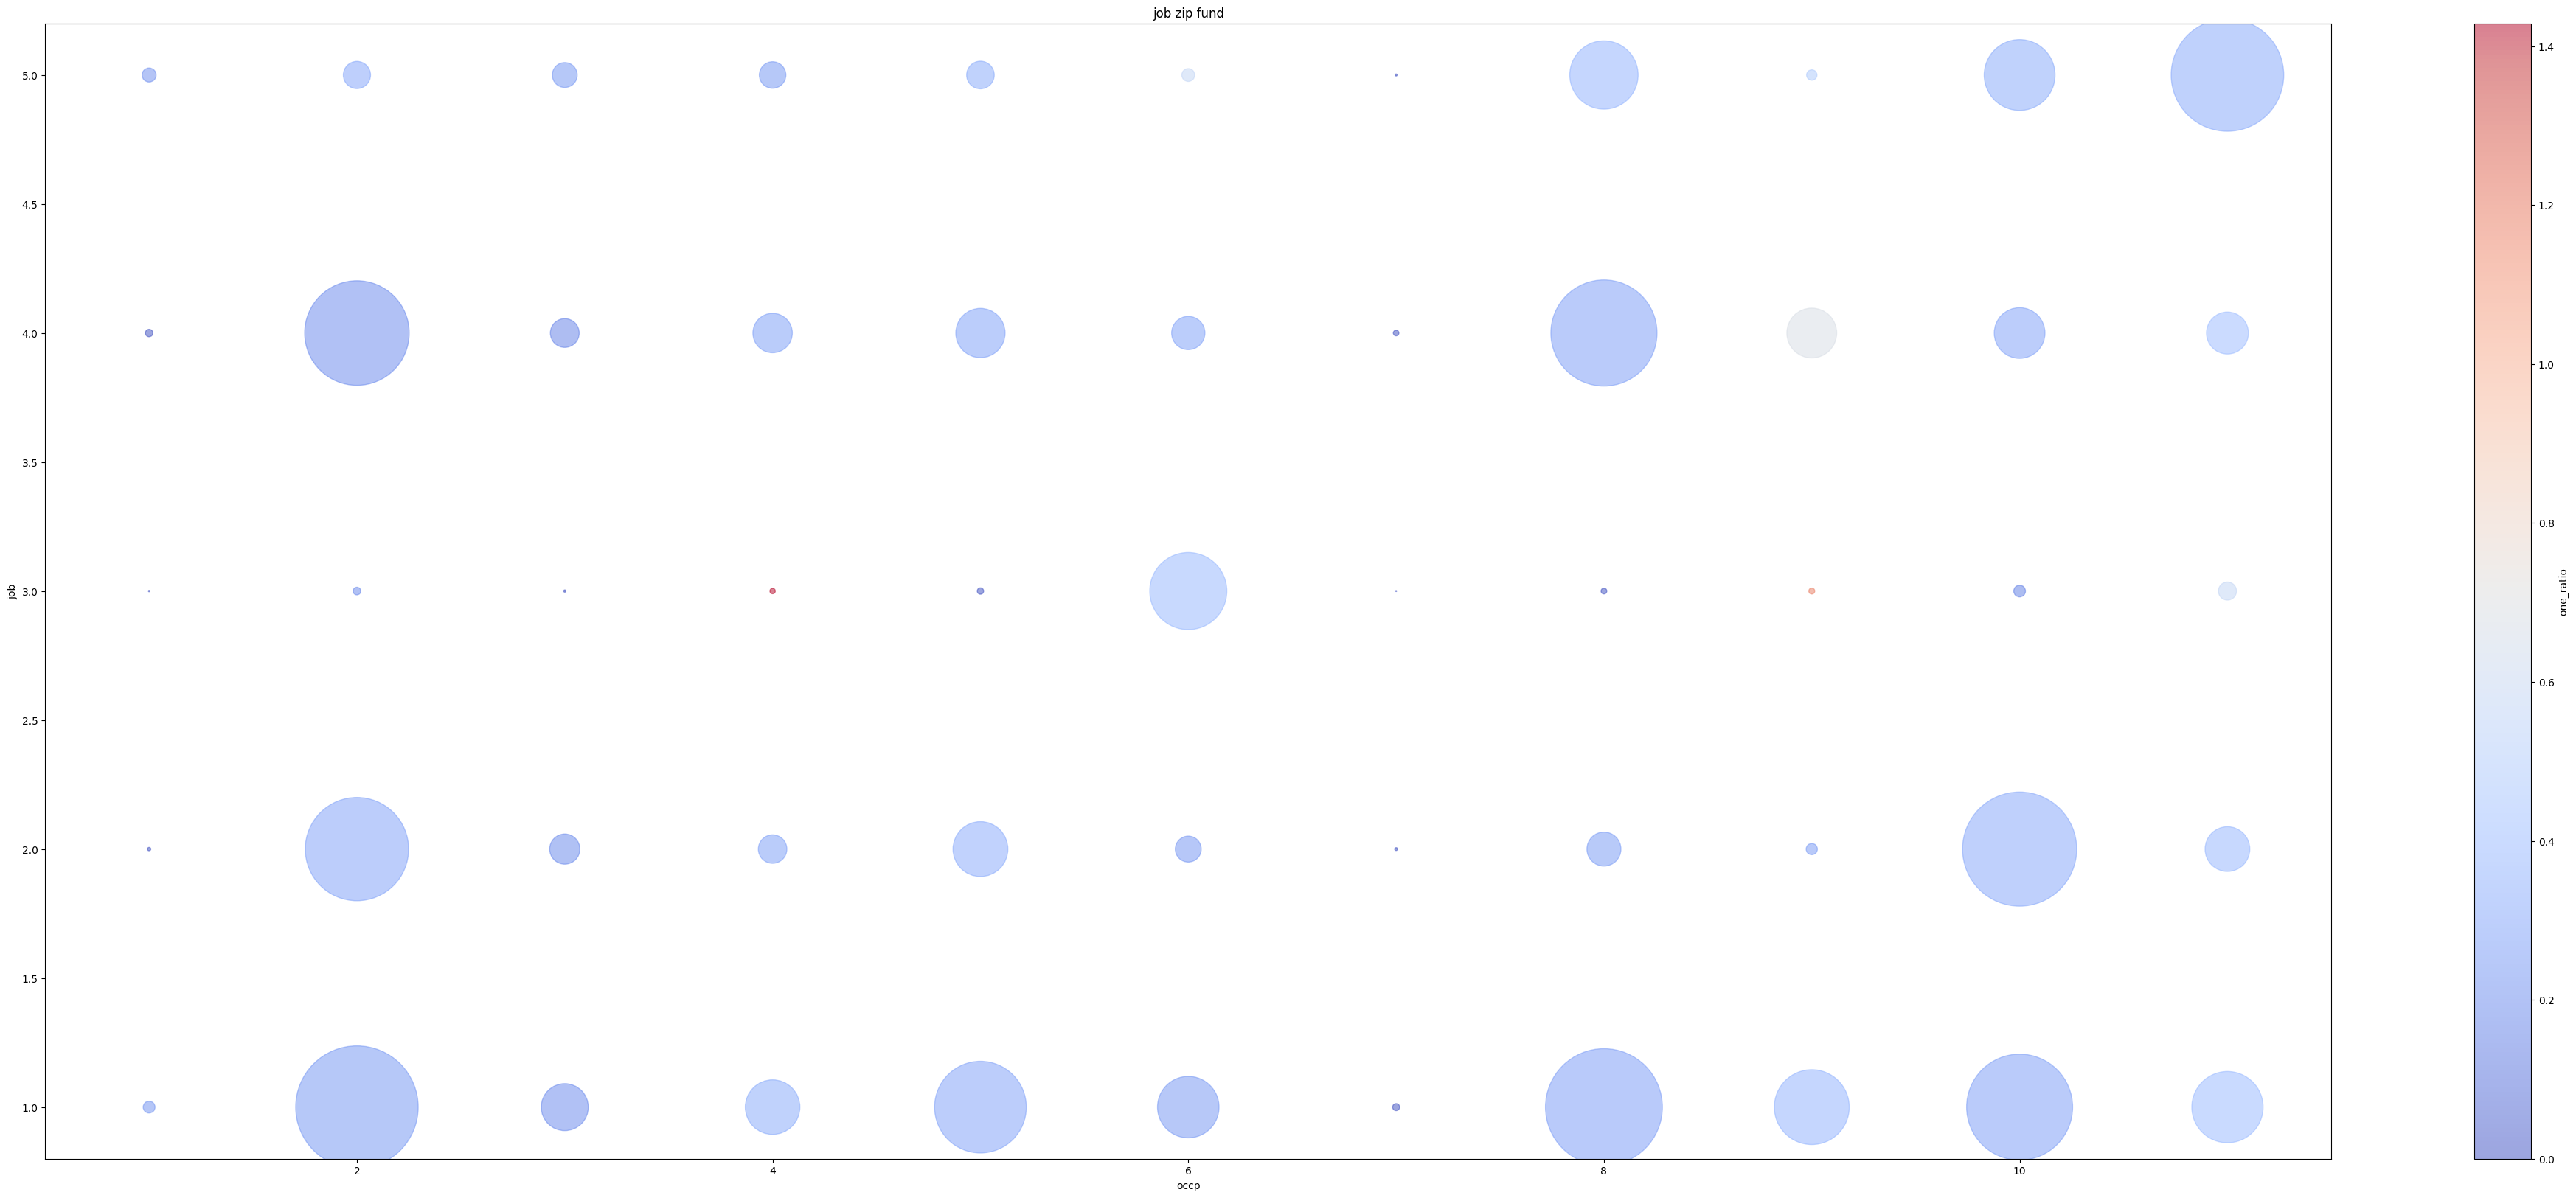

In [108]:
df1_train = pd.merge(df1_train, df3_train['rs_prod_2'], on='srno_2', how='left')
grouped = df1_train.groupby(['job', 'occp'])['rs_prod_2'].agg(['size', lambda x: (x == 1).sum()])

# 计算比例
grouped['one_count'] = grouped["<lambda_0>"]
grouped['one_ratio'] = grouped['one_count'] / grouped['size']

# 获取 x 和 y 的值
x = grouped.index.get_level_values('occp')
y = grouped.index.get_level_values('job')

# 获取每个组的大小和颜色
sizes = grouped['size'].values 
colors = grouped['one_ratio'].values*10

plt.figure(figsize=(50, 20))

# 绘制散点图，点的大小由 'sizes' 决定，颜色由 'colors' 决定
scatter = plt.scatter(x, y, s=sizes, c=colors, cmap='coolwarm', alpha=0.5)
plt.colorbar(scatter, label='one_ratio')
plt.xlabel("occp")
plt.ylabel("job")
plt.title("job zip fund")
plt.show()

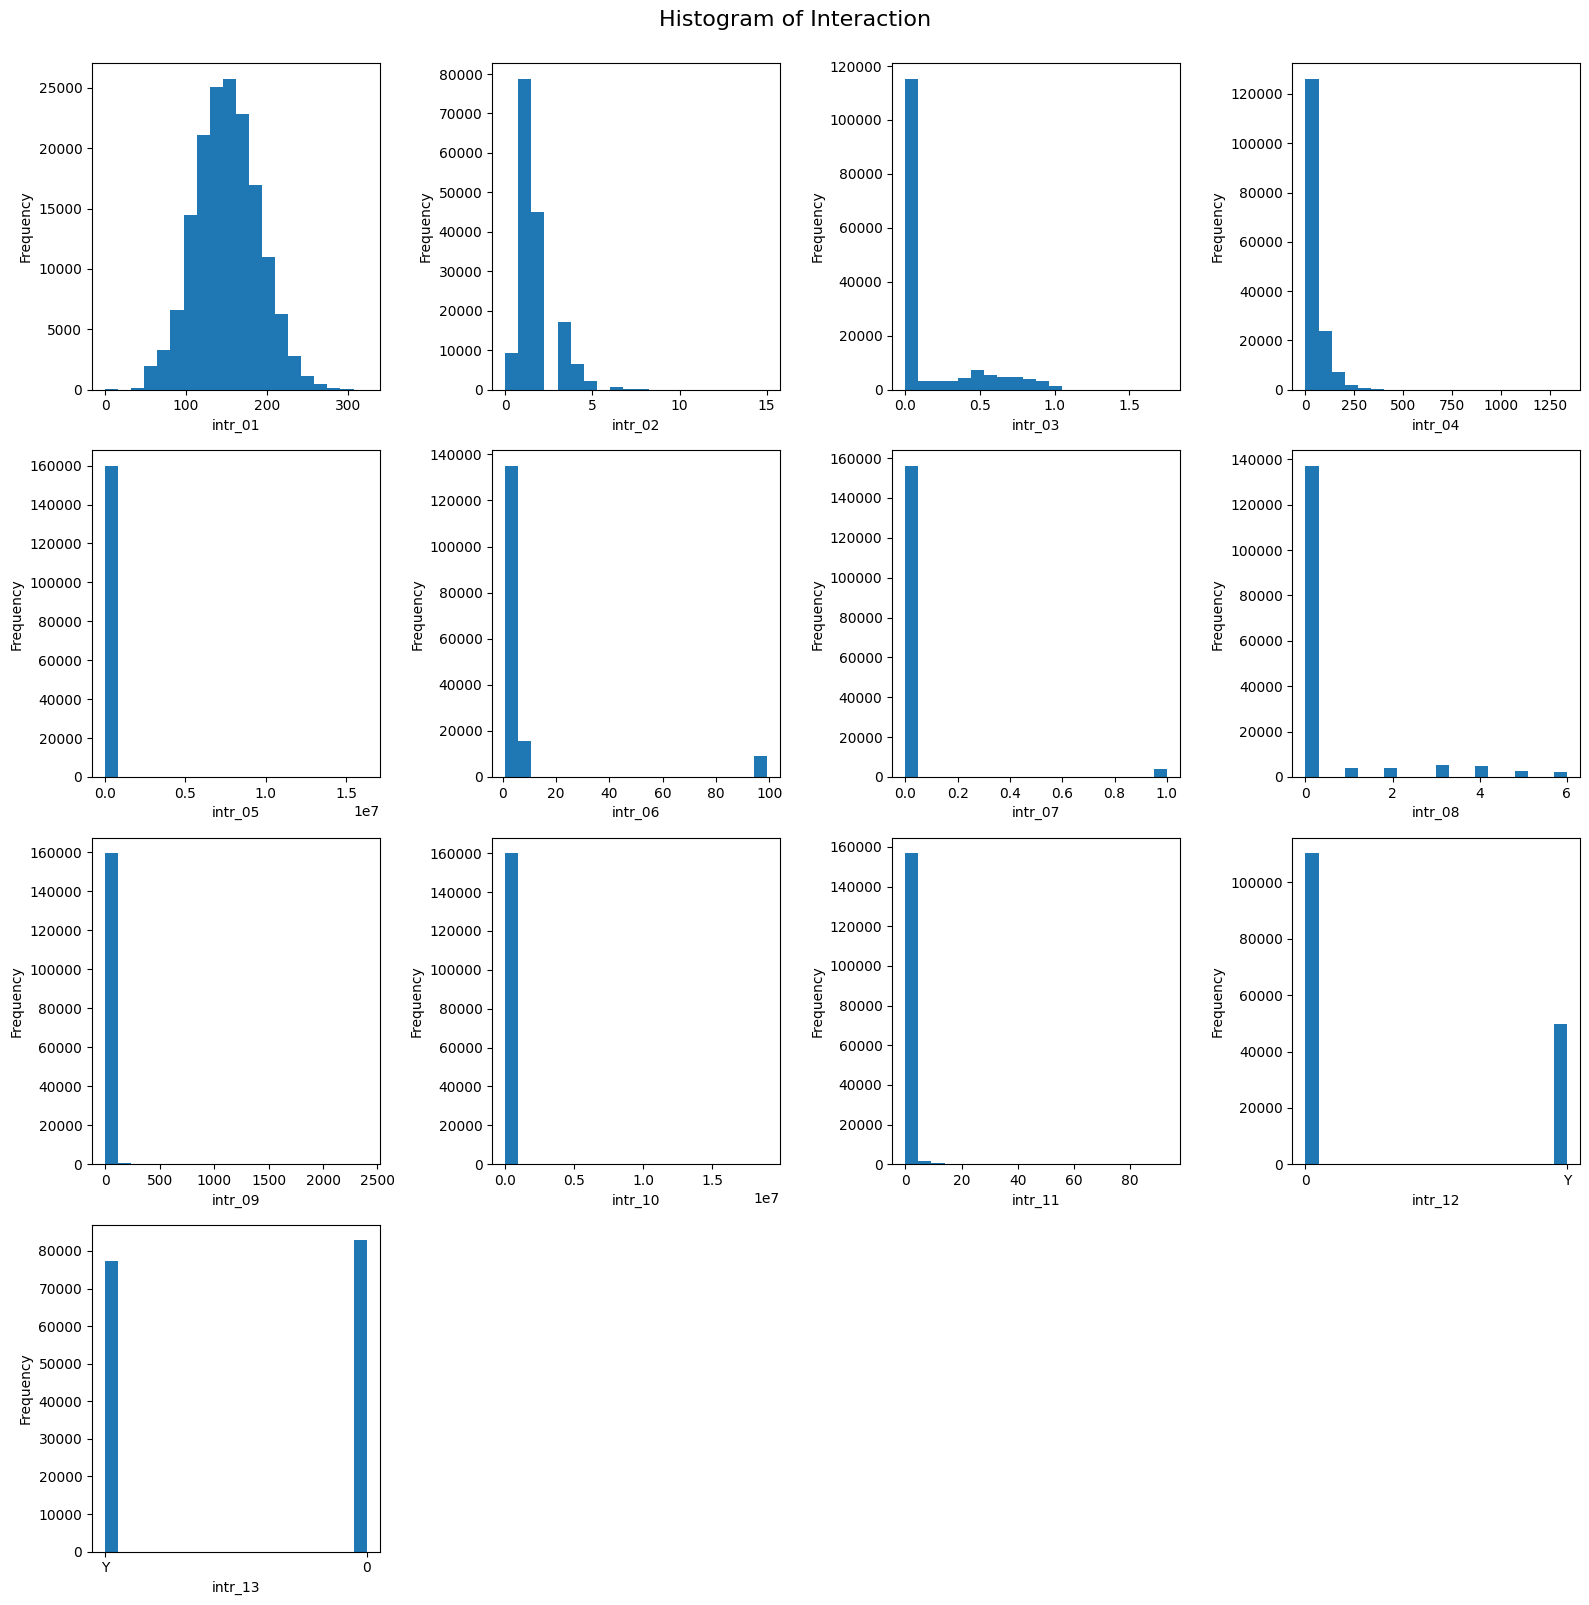

In [53]:
intr_columns = [col for col in df1_train.columns if col.startswith("intr_")]

num_rows = 4
num_cols = 4

plt.figure(figsize=(16, 16))

for i, column in enumerate(intr_columns):
    plt.subplot(num_rows, num_cols, i+1)
    plt.hist(df1_train[column], bins=20)  
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.suptitle("Histogram of Interaction", fontsize=16, y=1)
plt.tight_layout() 
plt.show()

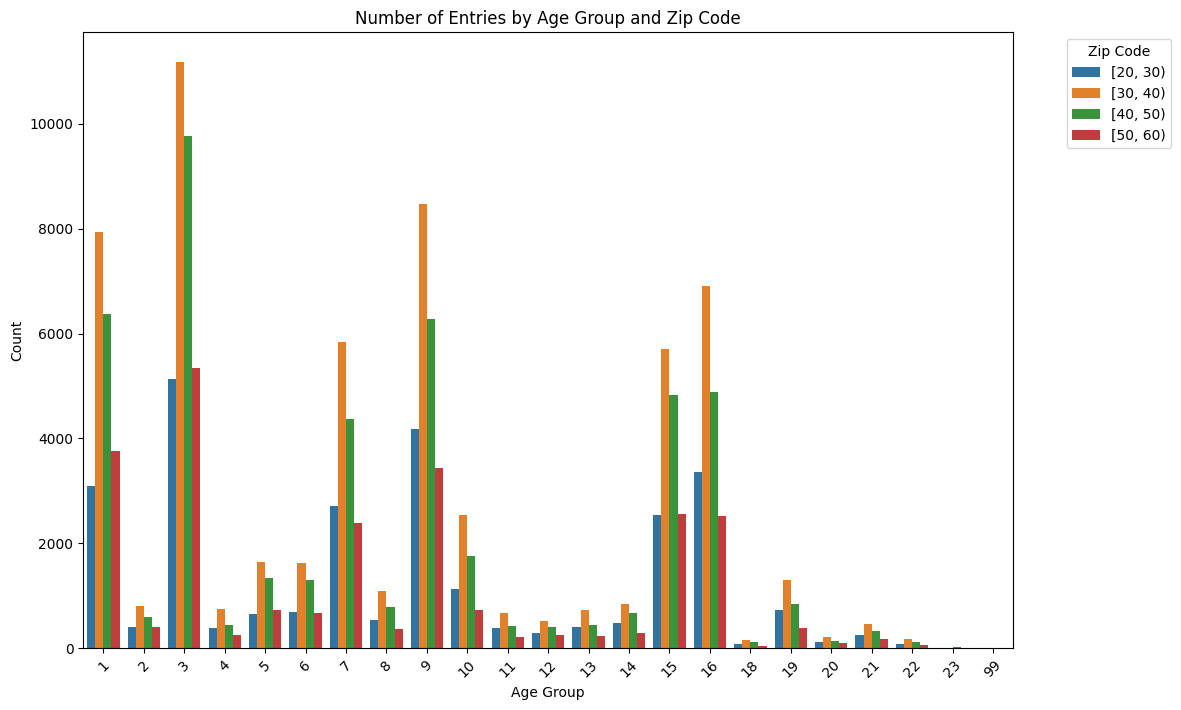

In [109]:
df1_train['age_group'] = pd.cut(df1_train['age'], bins=range(20,df1_train['age'].max()+10, 10), right=False)
df1_train = df1_train.drop(columns=['rs_prod_2'])
# 统计每个分组的数量
age_group_counts = df1_train['age_group'].value_counts().sort_index()

# 将区间转换为字符串
age_groups_str = [str(interval) for interval in age_group_counts.index]

group_counts = df1_train.groupby(['age_group', 'zip'], observed=False).size().reset_index(name='count')

# 使用 Seaborn 绘制条形图
plt.figure(figsize=(12, 8))
sns.barplot(x='zip', y='count', hue='age_group', data= group_counts)
plt.title('Number of Entries by Age Group and Zip Code')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Zip Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## XGboost


In [110]:
sub_dataframes = [group for _, group in df2_train.groupby(pd.to_datetime(df2['yyyymm'], format='%Y%m').dt.to_period('M'))]
sub_dataframes[0]


,srno_2,yyyymm,aum01,aum02,aum03,aum04,aum05,aum06,aum07,aum08,...,CNT_Exchange_A,CNT_Exchange_B,YN_Web_Active,YN_secur,CNT_WBMB_Login,YN_SLR,INV_ADV,rs_prod_1,rs_prod_2,rs_prod_3
0,1,202212,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,0,NaN,0,0,0,0
12,2,202212,467,467,0,0,0,0,0,0,...,0,0,NaN,NaN,0,NaN,0,0,0,0
24,3,202212,34,34,0,0,0,0,0,0,...,0,0,1.0,NaN,0,NaN,0,0,0,0
36,4,202212,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,0,NaN,0,0,0,0
48,5,202212,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,0,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399940,199996,202212,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,0,NaN,0,0,0,1
2399952,199997,202212,14,14,0,0,0,0,0,0,...,0,0,1.0,NaN,0,NaN,0,0,0,0
2399964,199998,202212,0,0,0,0,0,0,0,0,...,0,0,NaN,NaN,0,NaN,0,0,0,0
2399976,199999,202212,64538,64538,64538,0,0,0,0,0,...,0,0,1.0,NaN,3,NaN,0,0,0,1


In [140]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
df1_train['intr_12'] = pd.to_numeric(df1_train['intr_12'].replace({'Y': 1}))
df1_train['intr_13'] = pd.to_numeric(df1_train['intr_13'].replace({'Y': 1}))
df1_train['age_group'] = pd.Categorical(df1_train['age_group'])
df1_train['age_group'] = df1_train['age_group'].cat.codes + 1
X = df1_train
month_auc_scores = []
month_import_features = []
model = XGBClassifier()



for sub_data in sub_dataframes:
    y = pd.DataFrame(sub_data["rs_prod_3"])
    
    feature_importances = pd.DataFrame(index=X.columns)
    fold_auc_scores = []
    
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]  
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        ros = RandomOverSampler(random_state=42)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    
        model.fit(X_train_resampled, y_train_resampled)
        y_pred_proba = model.predict_proba(X_test)[:, 1] 
        auc = roc_auc_score(y_test, y_pred_proba)
        fold_auc_scores.append(auc)
        
        # 存储特征重要性
        feature_importances['Fold_{}'.format(fold)] = model.feature_importances_
        
    # 计算折叠的平均 AUC
    month_auc = np.mean(fold_auc_scores)
    mean_feature_importances = feature_importances.mean(axis=1)
    month_auc_scores.append(month_auc)
    month_import_features.append(mean_feature_importances)



In [147]:
print(month_auc_scores)

[0.7201658384146423, 0.7184093628537792, 0.7146032948089014, 0.7219461122787648, 0.7062446709131291, 0.7151214268120178, 0.7089285688797041, 0.7158361768884742, 0.7098352012696639, 0.710645914350699, 0.7087084135412567, 0.7201945412886128]


C:\Users\USER\AppData\Local\Temp\ipykernel_20324\2077542532.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(range(len(idxs)), mean_feature_importances[idxs], align='center')


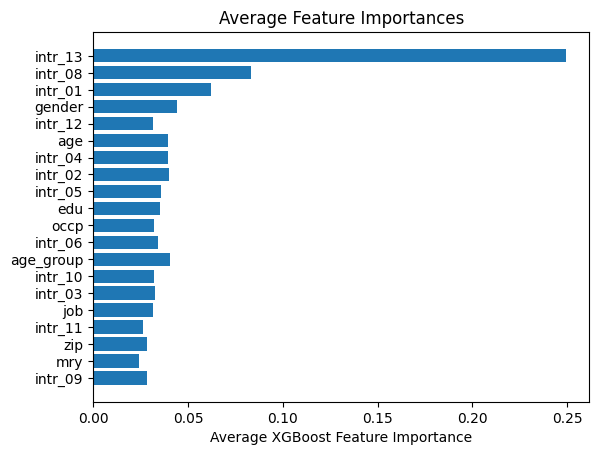

In [141]:

# Sort mean feature importances indices
idxs = np.argsort(month_import_features[0])[-20:]

# Set title
plt.title('Average Feature Importances')

# Create horizontal bar plot
plt.barh(range(len(idxs)), mean_feature_importances[idxs], align='center')

# y-axis labels
plt.yticks(range(len(idxs)), [mean_feature_importances.index[i] for i in idxs])

# x-axis label
plt.xlabel('Average XGBoost Feature Importance')

plt.show()

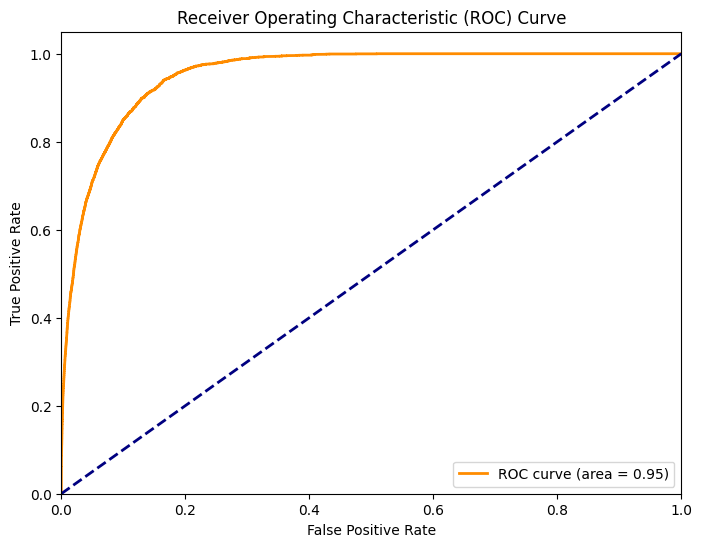

In [146]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = model.predict_proba(X_train_resampled)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_pred_proba)

roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## 隨機森林分析

In [ ]:
# pip install scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

merged_df = pd.read_csv('merged_df.csv')

# 分離特徵和目標變數
X = merged_df.drop(['rs_prod_3_df3'], axis=1)  # 特徵集
y = merged_df['rs_prod_3_df3']  # 目標變數

# 劃分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化隨機森林回歸模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 訓練模型
rf_model.fit(X_train, y_train)

# 進行預測
predictions = rf_model.predict(X_test)

# 評估模型
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
